# Gas Phase UED Processing Code
Written by LFH in Oct 2023. 
Adapted from code provided by Yusong Liu and Caidan Moore

## Standard Steps

1. __Reject images with high counts.__
    * Compared total counts of each image. This is done either based on selected images or based on the standard deviaion of all the images. 
2. __Optional: Subtract background images__
    * Some experiments collect background shots. An average of these is taken and the average is subtracted from each data image. 
    * Alternative method is to generate a background based on the average values of the corners of the images. Right now this is behaving poorly for me.  
3. __Remove outliers instances of identical pixels.__
    * This is generally referred to as removing xray hits or hot pixels. There are two functions for doing this. `rmv_xray_all` runs in parallel and should be used for large datasets and `cleanMean` takes in small data sets.
4. __Mask detector hole__
    * Currently using the code made by collaborators at SLAC as it automatically finds the mask position. This function uses the opencv package. Replaces the mask with nan values.  
    * Only works with small data. Need to figure out why and how to make work with a large data set.  
5. __Calculate static diffraction center.__
    * Using the method provided by collaborators at SLAC found in the `find_beam_center` function. Iteratively fits a circle to the data based on equivalent values in radial positions.  
    * Need to figure out a way to use the individual centers instead of the average. 
6. __Remove radial outliers.__
    * Filter out values which are beyond a threshold compared to equivalent values at other radial positions. This is automatically done in the `azimuthal_avg_correct` function which runs in the background in parallel when calling `get_azimuthal_average`. This function currently uses the multiprocessing package. Would like to switch to concurrent.futures package. __Need to edit__
7. __Apply median filter.__
    * Applies a median filter using the `scipy.ndimage.median_filter` function which requires a set size of grid to filter based on. Before doing this, need to change all nan values to their radial average equivalent.
8. __Calculate azimuthal average.__
    * See point 6. Repeat calculation.


### To Do

* Make flexible by using consistent names for things
* Create larger package instead of notebook

## Import Necessary Functions

In [1]:
# Standard Packages
import numpy as np
from math import exp, sqrt, floor
from tifffile import tifffile as tf
import glob
import matplotlib.pyplot as plt
from datetime import date
import scipy.interpolate as interp
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

#%matplotlib inline
from skimage import util


#ff stuff
from multiprocessing.dummy import Pool as ThreadPool

#saving notebook
import dill

# new code 
import GUED as gued

## Define Functions

### Save Notebook Session

In [2]:
def save_session(file_name):
    today = date.today()
    dill.dump_session(f'{file_name}_{today}.db')
    print("Session saved to ", file_name)

def load_session(file_name):
    file_name = file_name + '.db'
    dill.load_session(f'{file_name}.db')
    print(file_name, " session loaded")

### Cleaning Functions

In [3]:
def gaussian_filter_2d(data_array, sig=1):
    """Applies the scipy.ndimage.gaussian_filter() on the 2D data array. Returns filtered images"""
    gf_filtered = gaussian_filter(data_array, sig)
    return gf_filtered
    
def fit_high_s(data_array, x_vals, s_range, return_baseline=False):
    if len(data_array.shape) == 2:
        corrected_data = []
        baseline = []
        for i in range(len(data_array)):
            temp_data = data_array[i]
            coeff = np.polyfit(x_vals[s_range], temp_data[s_range], 2)
            line = np.polyval(coeff, x_vals[s_range])
            baseline.append(line)
            data_array[i, s_range] = temp_data[s_range] - line
            corrected_data.append(data_array[i])
            
    elif len(data_array.shape) == 1:
        coeff = np.polyfit(x_vals[s_range], data_array[s_range], 1)
        baseline = np.polyval(coeff, x_vals)
        
        corrected_data = data_array - baseline
    else:
        print("Data Array must be 1D or 2D array")
    
    corrected_data= np.array(corrected_data)
    
    if return_baseline == True:
        return corrected_data, baseline
    else:
        return corrected_data

### Center Finding

In [4]:
# def find_beam_center(I,center=[500,500],r=175,printr2='no',recursiontime=0):

#     recursiontime+=1
#     #up down right left,r away pixles average
#     fit_value=np.average([I[center[0]+r][center[1]],I[center[0]-r][center[1]],I[center[0]][center[1]+r],I[center[0]][center[1]-r]])
    
#     [X_f,Y_f]=np.where((I>0.999*fit_value) & (I<1.001*fit_value))
    
#     #plt.figure()
#     #plt.scatter(Y_f,X_f)
#     #plt.imshow(I)
#     a=len(X_f)
#     i=0
#     #delete fit_points which are too far away from fit_circle, range from 0.5r to 1.5r
#     while(i<a):
#         ri2=(X_f[i]-center[0])**2+(Y_f[i]-center[1])**2
#         if (ri2>(1.5*r)**2) or (ri2<(0.5*r)**2):
#             X_f=np.delete(X_f,i)
#             Y_f=np.delete(Y_f,i)
#             i-=1
#             a-=1
#         i+=1
#     center_new,r_new=fit_circle([X_f,Y_f],printr2)
    
#     if r_new==0:
#         return [0,0]
#     elif ((center[0]-center_new[0])**2 +(center[1]-center_new[1])**2) <=1 :
#         #new center pretty close to old center
#         return center_new
#     elif recursiontime>=10:
#         return [0,0]
#     else:
#         #else: iterate
#         return find_beam_center(I,center_new,r_new,recursiontime=recursiontime)
    
    
    
# def fit_circle(fit_points,printr2='yes'):
    
#     #circle function: ax+by+c=-(x^2+y^2)
    
#     A=np.empty((len(fit_points[0]),3))
#     B=np.empty(len(fit_points[0]))
    
#     for i in range(len(fit_points[0])):
#         B[i]=-(fit_points[0][i]**2+fit_points[1][i]**2)
#         A[i][0]=fit_points[0][i]
#         A[i][1]=fit_points[1][i]
#         A[i][2]=1
    
#     #A[i]=[xi,yi,1], B[i]=-(xi^2+yi^2), par=[a,b,c]
#     #namely A*par=B, least square method
#     if np.linalg.det(np.dot(A.T,A)) == 0:
#         return [],0
#     par=np.dot(np.dot(np.linalg.inv(np.dot(A.T,A)),A.T),B)
    
#     #correlation coeff, if not very close to 1(less than 3 nines), be careful
#     if printr2=='yes':
#         y_ave=np.mean(B)
#         r2=np.sum((np.dot(A,par)-y_ave)**2)/np.sum((B-y_ave)**2)
#         print(r2)
    
#     center_new=[round(-par[0]/2),round(-par[1]/2)]
#     r_new=round(np.sqrt(par[0]**2+par[1]**2-4*par[2])/2)
    
#     return center_new,r_new

def find_beam_center(I,center=[500,500],r=200,printr2='no',recursiontime=0):

    recursiontime+=1
    #up down right left,r away pixles average
    # fit_value=average([I[center[0]+r][center[1]],I[center[0]-r][center[1]],I[center[0]][center[1]+r],I[center[0]][center[1]-r]])
    fit_value= np.average([I[round(center[0])+r][round(center[1])],I[round(center[0])-r][round(center[1])],I[round(center[0])][round(center[1])+r],I[round(center[0])][round(center[1])-r]])

    [X_f,Y_f]= np.where((I>0.999*fit_value) & (I<1.001*fit_value))

    a=len(X_f)
    i=0
    #delete fit_points which are too far away from fit_circle, range from 0.5r to 1.5r
    while(i<a):
        ri2=(X_f[i]-center[0])**2+(Y_f[i]-center[1])**2
        if (ri2>(1.5*r)**2) or (ri2<(0.5*r)**2):
            X_f=np.delete(X_f,i)
            Y_f=np.delete(Y_f,i)
            i-=1
            a-=1
        i+=1
            
    center_new,r_new=fit_circle([X_f,Y_f],printr2)
    
    if r_new==0:
        return [0,0]
    elif ((center[0]-center_new[0])**2 +(center[1]-center_new[1])**2) <=1 :
        #new center pretty close to old center
        return center_new
    elif recursiontime>=10:
        return [0,0]
    else:
        #else: iterate
        return find_beam_center(I,center_new,r_new,recursiontime=recursiontime)
    
    
    
def fit_circle(fit_points,printr2='yes'):
    
    #circle function: ax+by+c=-(x^2+y^2)
    
    A= np.empty((len(fit_points[0]),3)) # Find center for 3 thimes
    B= np.empty(len(fit_points[0]))
    
    for i in range(len(fit_points[0])):
        B[i]=-(fit_points[0][i]**2+fit_points[1][i]**2)
        A[i][0]=fit_points[0][i]
        A[i][1]=fit_points[1][i]
        A[i][2]=1
    
    #A[i]=[xi,yi,1], B[i]=-(xi^2+yi^2), par=[a,b,c]
    #namely A*par=B, least square method
    if np.linalg.det(np.dot(A.T,A)) == 0:
        return [],0
    par=np.dot(np.dot(np.linalg.inv(np.dot(A.T,A)),A.T),B)
    
    #correlation coeff, if not very close to 1(less than 3 nines), be careful
    if printr2=='yes':
        y_ave=np.mean(B)
        r2=sum((np.dot(A,par)-y_ave)**2)/sum((B-y_ave)**2)
        print(r2)
    
    center_new=[(-par[0]/2),(-par[1]/2)] # no-Round the center, not working for the moment
    r_new=round(np.sqrt(par[0]**2+par[1]**2-4*par[2])/2) # no-round the r range, not working for the moment
    # print('ct found:'+str(center_new))
    
    # center_new=[round(-par[0]/2),round(-par[1]/2)] # Round the center
    # r_new=round(sqrt(par[0]**2+par[1]**2-4*par[2])/2) # round the r range
    
    return center_new,r_new

## Reading in Data and Visualizing

### Defining path -- Uses * to make more accessible for reading in multiple scan files

In [5]:
dataPath = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\nitrophenyl code\\20180823\\Run\\'
runPath = "\\*\\*\\*\\ANDOR1_*.tif"


bkg_path = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Background/*/*/ANDOR1_*.tif'


newPath = dataPath + runPath
print(newPath)
print(bkg_path)

files = glob.glob(newPath) 
bkg_files = glob.glob(bkg_path)
print(len(files))
print(len(bkg_files))

C:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\nitrophenyl code\20180823\Run\\*\*\*\ANDOR1_*.tif
/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Background/*/*/ANDOR1_*.tif
1998
0


### Reading in All Data and Getting Total Counts -- Lauren's Version

Loading diffraction signal


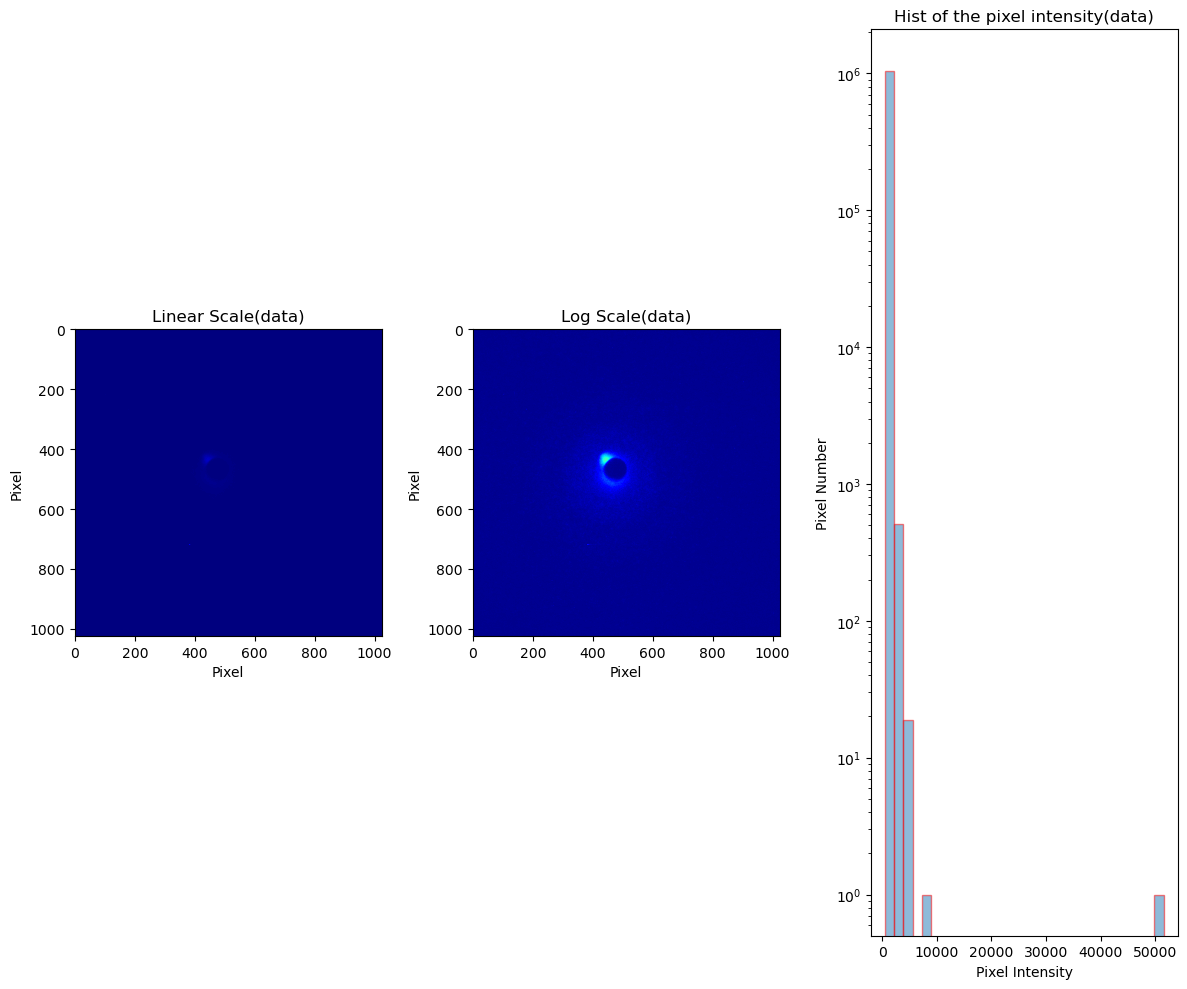

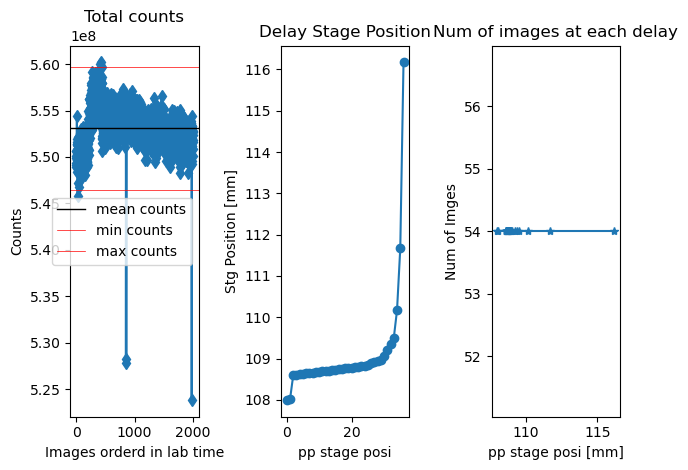

In [6]:
print('Loading diffraction signal');
data_array, stage_positions, file_numbers, counts = gued.get_image_details(files[:], plot=True, sort=True)

counts_mean = np.mean(counts)        # Mean values of Total Counts of all images
counts_std  = np.std(counts)         # the STD of all the tc for all the iamges
uni_stage = np.unique(stage_positions)# Pump-probe stage position


## Filtering Out Bad Shots Based on Total Counts

6  number of files removed from  1998  initial files


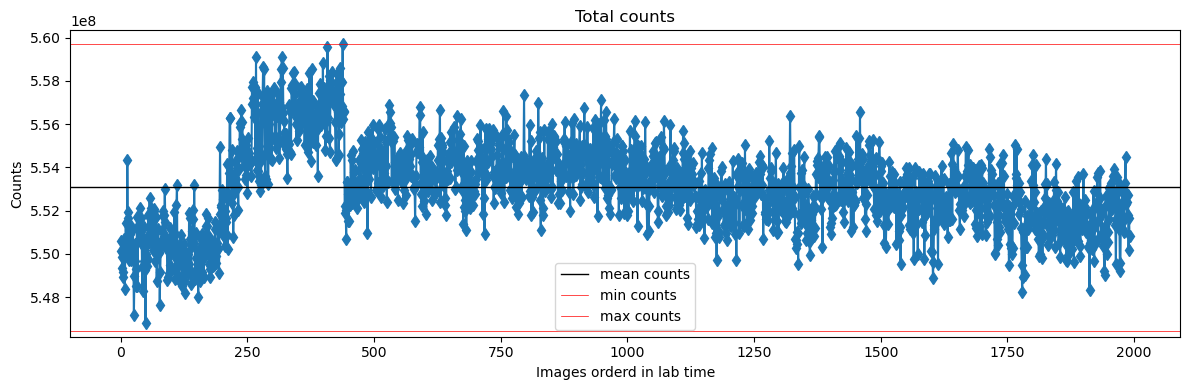

In [7]:
good_data, good_stage, good_order, good_counts = gued.remove_counts(data_array, stage_positions, file_numbers, counts, plot=True)

## Averaging Based on Delay Position

In [8]:
good_data.shape

(1992, 1024, 1024)

In [9]:
%%time
stage_len = len(uni_stage);               #  Number of delays
stage_ave = np.ones((stage_len,1024,1024)); #  Delay dependent averaged pp images
stage_ave_mk = np.ones((stage_len,1024,1024)); #  Delay dependent averaged pp images with mask

if stage_len>20:
    prt_count = 5
else:
    prt_count = 1  
for i in range(stage_len):
    if i%prt_count == 0:
        print('Averaging data at stage posi # '+ str(i) + ', ' + str(uni_stage[i]) + ' mm') # Obtain a sub array to save the data in one delay
    stage_data = good_data[np.where(good_stage==uni_stage[i])[0]];
    stage_ave[i] = np.nanmean(stage_data,axis=0); # no subtracting background

    


Averaging data at stage posi # 0, 108.0 mm
Averaging data at stage posi # 5, 108.63 mm
Averaging data at stage posi # 10, 108.68 mm
Averaging data at stage posi # 15, 108.73 mm
Averaging data at stage posi # 20, 108.78 mm
Averaging data at stage posi # 25, 108.85 mm
Averaging data at stage posi # 30, 109.05 mm
Averaging data at stage posi # 35, 111.67 mm
CPU times: total: 4.95 s
Wall time: 10.4 s


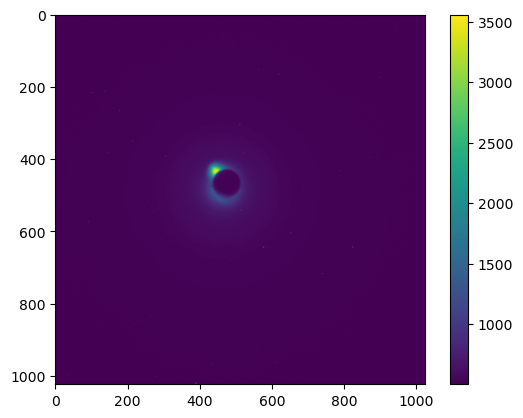

In [10]:
plt.figure()
plt.imshow(stage_ave[0])
plt.colorbar()
plt.show()

del good_data, good_stage, good_order

## Finding Diffraction Center -- Before Averaging Cuong's Code

In [11]:
%%writefile gued_globals.py
### Global Variables for entire code
CENTER_GUESS = (460, 460)
RADIUS_GUESS = 40
DISK_RADIUS = 3
CORNER_RADIUS = 20
CHECK_NUMBER = 50

MASK_CENTER = [475, 475]
MASK_RADIUS = 45
ADDED_MASK = [[440, 435, 30]]

Overwriting gued_globals.py


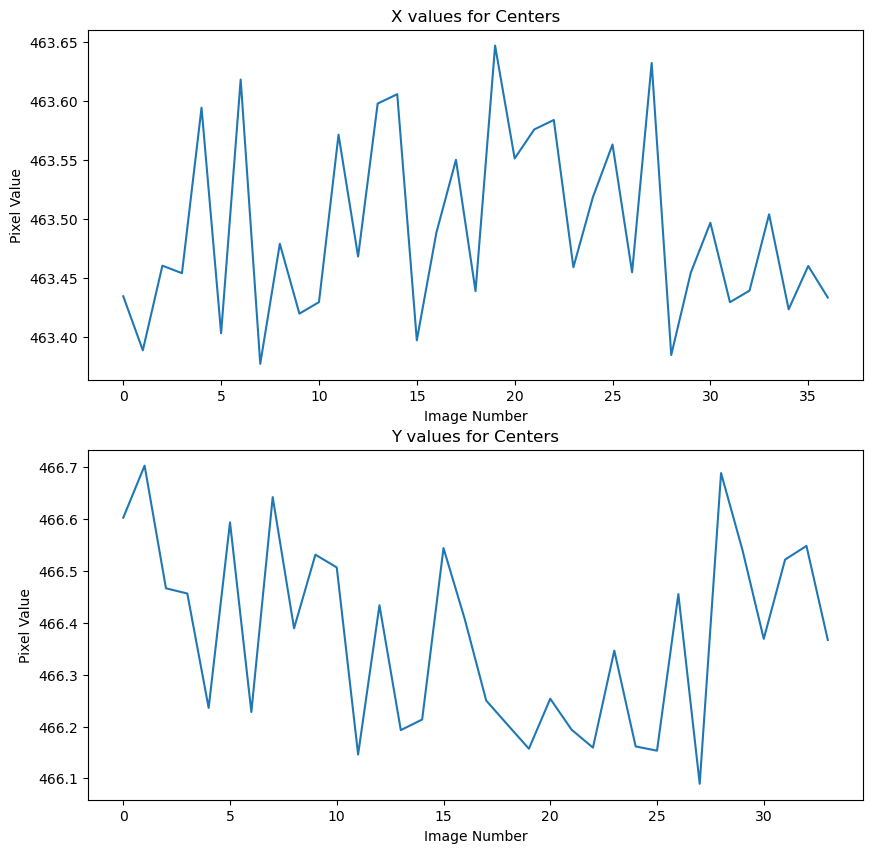

Averaged ctr is (463.49131673834546, 466.39332654124263)
Percentage of images where the center finding failed (i.e., found the guess value): 0.0


In [12]:
# only works when done before other steps...
center_x, center_y = gued.find_center_pool(stage_ave, plot=True)

## Generate Background Based on Corners

<Figure size 1200x400 with 0 Axes>

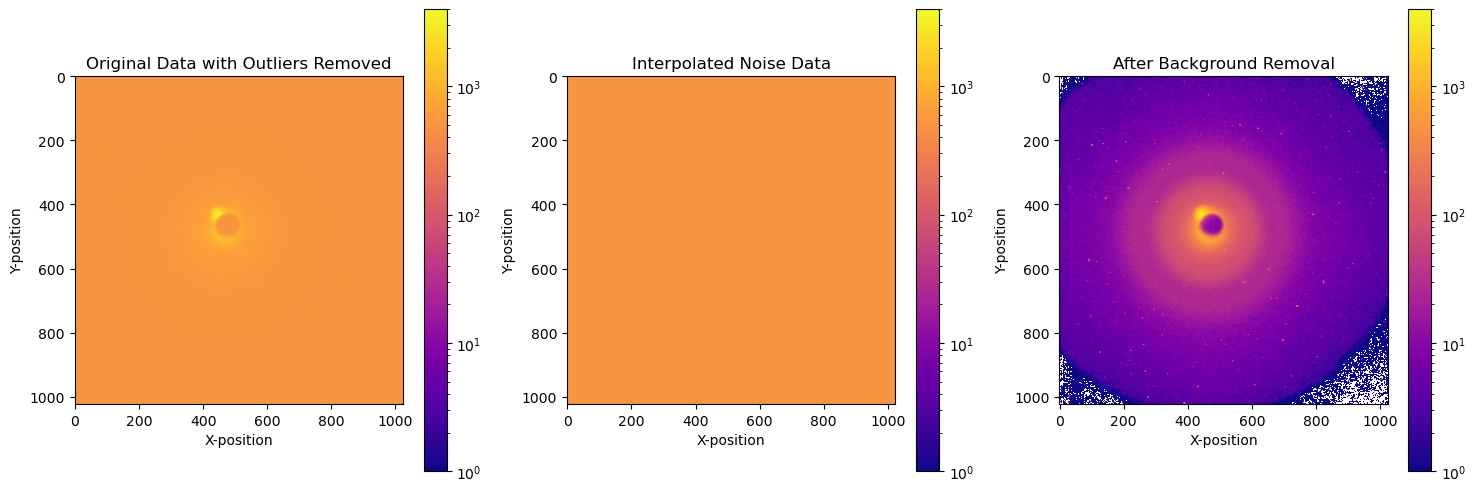

In [13]:
clean_data = gued.remove_background_pool(stage_ave, plot=True)

## Removing Hot Pixels -- Runs in Parallel

Removing hot pixels from all data


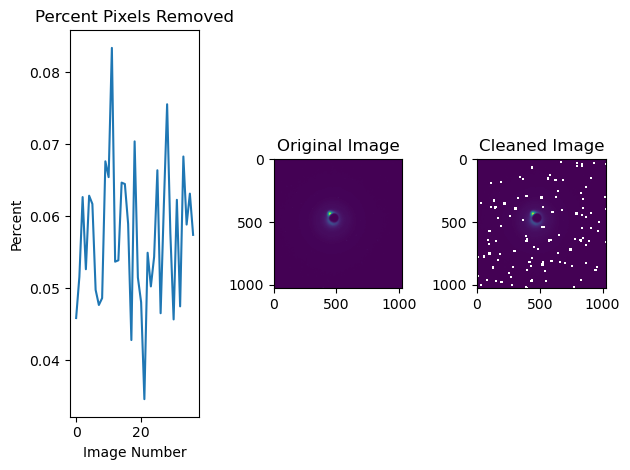

In [14]:
new_data = gued.remove_xrays_pool(clean_data, plot=True)

## Masking Beam Block

c:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\Coding Lab Notebook\GUED_Analysis\GUED.py:983: RuntimeWarning: Mean of empty slice
  masked_mean = np.nanmean(masked_data, axis=0)


(37, 1024, 1024)


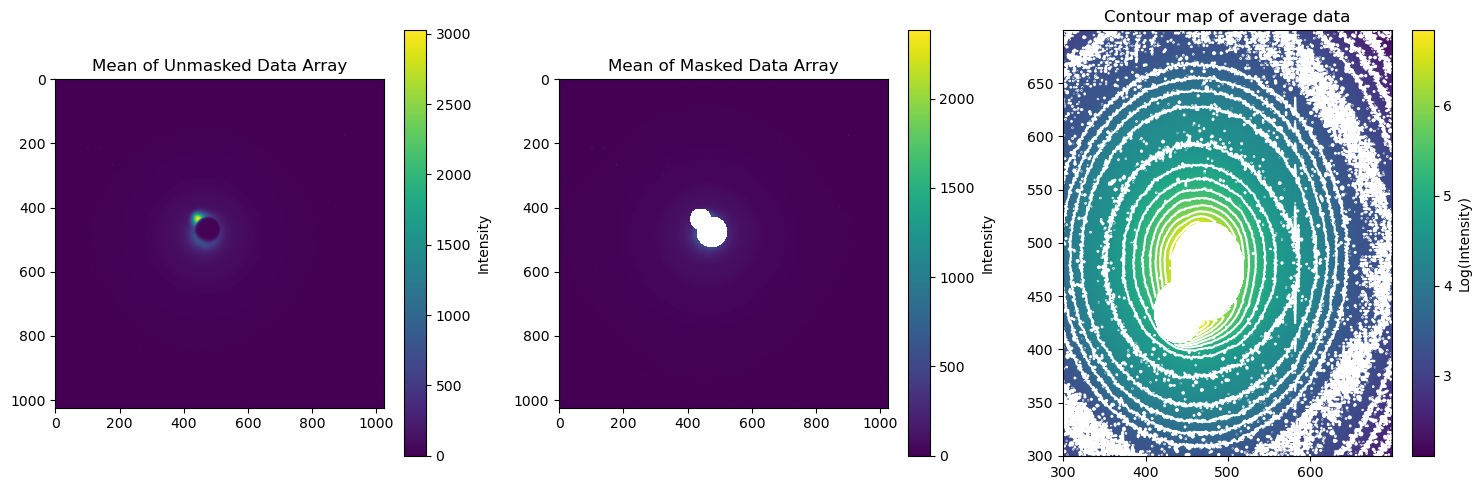

In [15]:
masked_data = gued.apply_mask(new_data, plot=True)

## Remove Radial Outliers

Done cleaning image 0
Done cleaning image 5
Done cleaning image 10
Done cleaning image 15
Done cleaning image 20
Done cleaning image 25
Done cleaning image 30
Done cleaning image 35


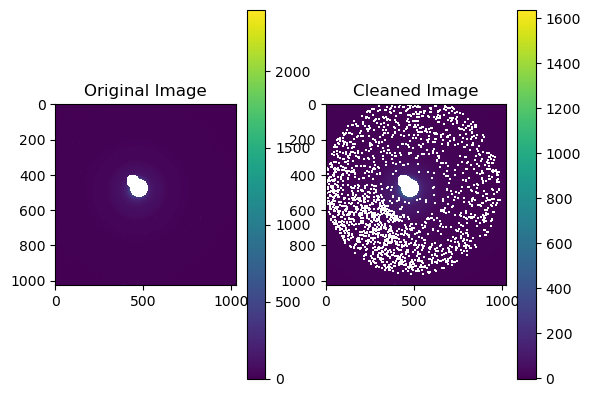

In [16]:
center = [489, 464]
cleaned_data = []

for i in range(len(masked_data)):
    cleaned = gued.cleaning_2d_data(masked_data[i], center)
    cleaned_data.append(cleaned)
    if i%5 == 0:
        print(f"Done cleaning image {i}")

cleaned_data = np.array(cleaned_data)


plt.figure()
plt.subplot(1,2,1)
plt.imshow(masked_data[0])
plt.colorbar()
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(cleaned_data[0])
plt.colorbar()
plt.title("Cleaned Image")
plt.show()

## Clean After Averaging

Cleaning all data with concurrent.futures.ProcessPoolExecutor
(37, 1024, 1024)
Finished cleaning!!


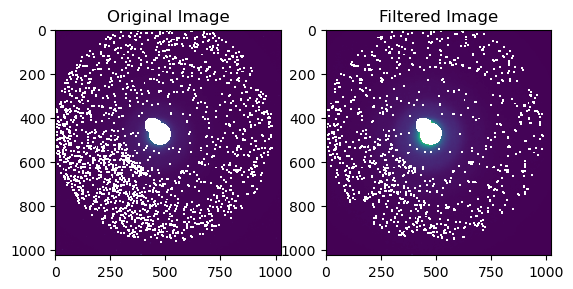

In [17]:

clean_data = gued.median_filter_pool(cleaned_data)
clean_data = np.array(clean_data)
counts_clean = gued._get_counts(clean_data)

counts_clean_mean = np.mean(counts_clean)
counts_clean_std = np.std(counts_clean)

## Finding Diffraction Center -- After Processing

Right now it is only worthwhile to run this on the stage averaged data as it takes a very long time. Ultimately will try to get working in parallel in order to find the center of each individual image. __Note:__ occasionally it returns a 0, 0 value for the centers. The average of all non-zero values are taken and then each zero is replaced with the average center. Test this vs lab time.

In [18]:
stage_ave = clean_data
stage_ave.shape

(37, 1024, 1024)

In [19]:
%%time

x_centers = []
y_centers = []
for i in range(len(stage_ave)):
    center = find_beam_center(stage_ave[i],center=[400,400],r=200)
    x_centers.append(center[0])
    y_centers.append(center[1])
    if i%1 == 0:
        print('Found center of ' + str(center)+' stage_position ' + str(uni_stage[i]))
x_centers = np.array(x_centers)
y_centers = np.array(y_centers)
centers = x_centers, y_centers
x_ave = np.mean(x_centers[np.where(x_centers > 0)[0]])
y_ave = np.mean(y_centers[np.where(y_centers > 0)[0]])
x_centers[np.where(x_centers == 0)[0]] = x_ave
y_centers[np.where(y_centers == 0)[0]] = y_ave
center_ave = x_ave, y_ave
print(r'Averaged ctr is ' + str(center_ave))

Found center of [488.1568282109379, 463.5523766988059] stage_position 108.0
Found center of [487.6336246354473, 463.66127081360634] stage_position 108.01
Found center of [487.46434216071316, 463.8797236922617] stage_position 108.6
Found center of [488.0947359407117, 463.52172739489674] stage_position 108.61
Found center of [487.55055640664847, 462.62976835981306] stage_position 108.62
Found center of [489.11755513929296, 464.96961179777486] stage_position 108.63
Found center of [487.96393325194936, 464.0531612615423] stage_position 108.64
Found center of [487.68899922293167, 463.61575015283046] stage_position 108.65
Found center of [487.6972175987171, 464.6412817291781] stage_position 108.66
Found center of [488.0481538302346, 462.70329780394644] stage_position 108.67
Found center of [487.6173982076073, 464.1749453056558] stage_position 108.68
Found center of [487.7271451403749, 464.50038323856774] stage_position 108.69
Found center of [488.47420413046325, 464.07081062203144] stage_pos

## Azimuthal Averaging -- SLAC Way

In [24]:
def azimuthal_average(image, center=None, binsize=1.0):
    """
    Compute the azimuthal average of a 2D radially symmetric image, ignoring np.nan values.

    Parameters:
    - image: 2D numpy array, the input image.
    - center: tuple (x, y), the center around which to compute the average. If None, use the center of the image.
    - binsize: float, the size of the bins for averaging.

    Returns:
    - radial_prof: 1D numpy array, the azimuthally averaged radial profile.
    """
    # Ensure the input image is a 2D array
    assert image.ndim == 2, "Input image must be a 2D array"

    # Get the image dimensions
    y, x = np.indices(image.shape)

    if center is None:
        center = np.array([image.shape[1]//2, image.shape[0]//2])

    r = np.hypot(x - center[0], y - center[1])
    r = r.astype(int)

    # Create a mask for non-NaN values
    valid_mask = ~np.isnan(image)
    
    # Apply the mask to the image and radius
    image = image[valid_mask]
    r = r[valid_mask]

    # Calculate the radial profile
    tbin = np.bincount(r, weights=image)
    nr = np.bincount(r)

    radial_prof = tbin / nr

    return radial_prof


C:\Users\laure\AppData\Local\Temp\ipykernel_21924\2463201346.py:36: RuntimeWarning: invalid value encountered in divide
  radial_prof = tbin / nr


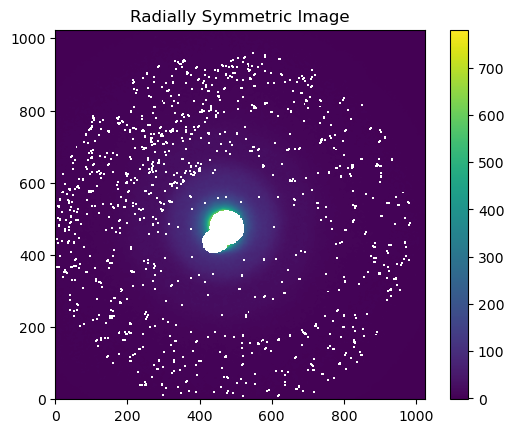

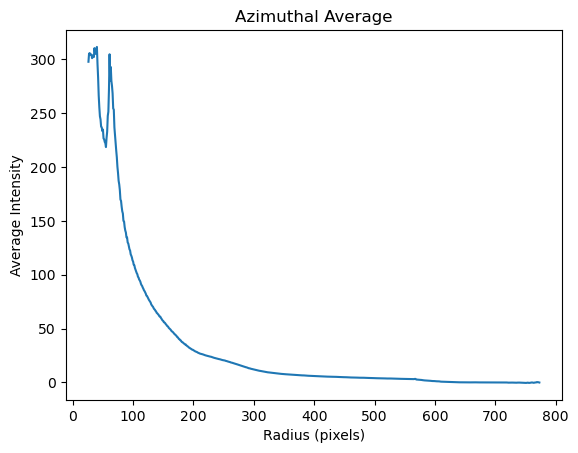

In [26]:
azi_data = []

for i in range(len(stage_ave)):
    azi = azimuthal_average(stage_ave[i], center)
    azi_data.append(azi)

azi_data = np.array(azi_data)

# Plot the results
plt.figure()
plt.imshow(stage_ave[0], origin='lower', extent=[0, 1024, 0, 1024])
plt.colorbar()
plt.title('Radially Symmetric Image')
plt.figure()
plt.plot(azi_data[0])
plt.title('Azimuthal Average')
plt.xlabel('Radius (pixels)')
plt.ylabel('Average Intensity')
plt.show()

In [ ]:
def azimuthal_avg_correct(args):
    """Returns the azimuthal average of a diffraction image based on the radial distance of the x, y positions in the image."""
    data, x, y = args
    r_max=len(x)
    I=np.empty(r_max)
    for ri in range(r_max):
        I_r=data[x[ri],y[ri]]
        ave=np.nanmean(I_r)
        sigma=np.nanstd(I_r)
        I_r[np.abs(I_r-ave)>=5*sigma]=np.nan
        I[ri]=np.nanmean(I_r)
    return I

def get_azimuthal_average(data,x,y):
    """Runs the azimuthal average function in parallel for large data sets."""
    p = ThreadPool(3)
    I=p.map(azimuthal_avg_correct, [(data_i,x,y) for data_i in data]) 
    return np.array(I)

X_CENTER = center_ave[0]
Y_CENTER = center_ave[1]
GRID_SIZE = 1024

pointer = np.empty((1024,1024))
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        pointer[i,j]=int(np.sqrt((i-X_CENTER)**2+(j-Y_CENTER)**2))
img_r_max = int(min(X_CENTER, Y_CENTER, GRID_SIZE-X_CENTER, GRID_SIZE-Y_CENTER))
x=[];y=[]
for ri in range(img_r_max):
    [X_temp,Y_temp]=np.where(pointer==ri)
    x.append(X_temp)
    y.append(Y_temp)
print(r'max Q index is ' + str(img_r_max));
r_max=len(x)

azi_data = get_azimuthal_average(stage_ave, x, y)

max Q index is 464


C:\Users\laure\AppData\Local\Temp\ipykernel_20196\1538666883.py:8: RuntimeWarning: Mean of empty slice
  ave=np.nanmean(I_r)
C:\Users\laure\AppData\Local\Temp\ipykernel_20196\1538666883.py:11: RuntimeWarning: Mean of empty slice
  I[ri]=np.nanmean(I_r)


## Normalize Azimuthal Averages to Baseline

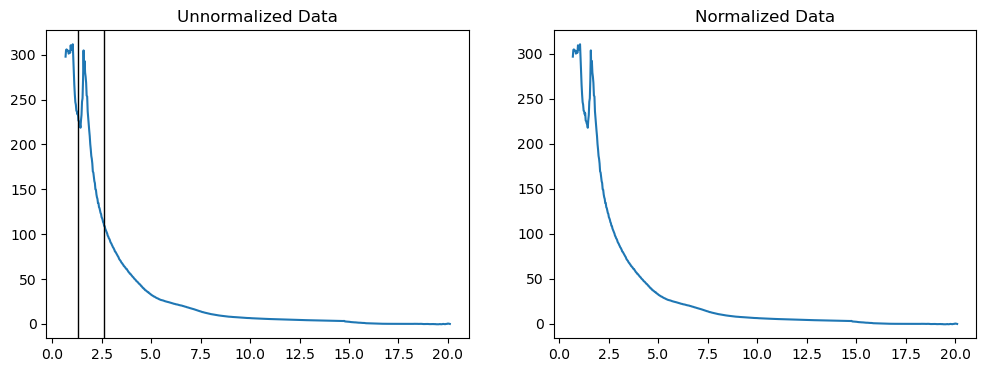

In [30]:
min_val = 50
max_val = 100
norm_data = gued.normalize_to_baseline(azi_data) 

s_cali = 0.026
#posi_0    = 154.405 # The reference T0
#posi_0 = 108.61
posi_0 = 26.9
s = np.arange(0,len(azi_data[0]))*s_cali # The Q axis

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(s, azi_data[0])
plt.axvline(x = s[min_val], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = s[max_val], color = 'k', linestyle = '-',linewidth=1);
plt.title("Unnormalized Data")

plt.subplot(1,2,2)
plt.plot(s, norm_data[0])
plt.title("Normalized Data")
plt.show()

## Plotting the Time-Dependent Signal

C:\Users\laure\AppData\Local\Temp\ipykernel_21924\4169235399.py:14: RuntimeWarning: Mean of empty slice
  norm_ref = np.nanmean(norm_data[:N_ref],axis=0);         # Reference signal before T0
C:\Users\laure\AppData\Local\Temp\ipykernel_21924\4169235399.py:32: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


98


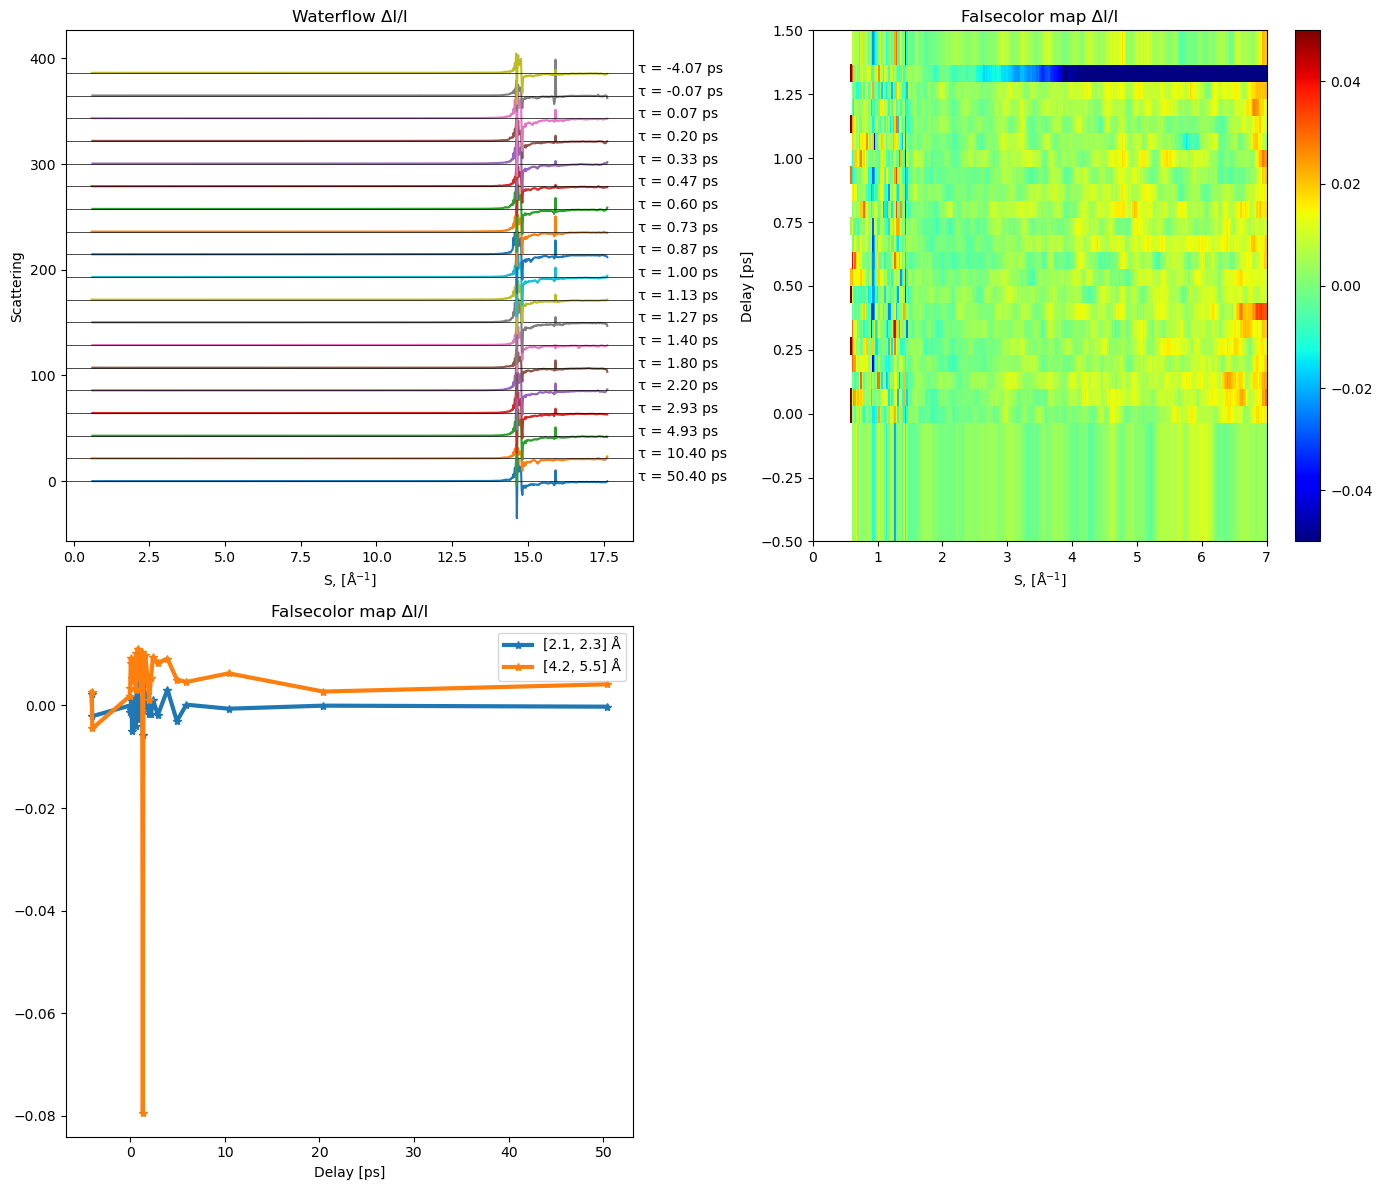

In [32]:
# (3) Plot the figure: Plot the time-dependent signal
angs = '\u00C5'; # angstrom sign
s_cali = 0.0228 # S calibration in experiment
#s_cali = 0.02134
#posi_0    = 154.405 # The reference T0
posi_0 = 108.61
s = np.arange(0,len(azi_data[0]))*s_cali # The Q axis
realtime = (uni_stage-posi_0)/0.15  # Delay axis in ps

if stage_len<5: # Make up the reference signals
    N_ref = 2
else:
    N_ref = 3
norm_ref = np.nanmean(norm_data[:N_ref],axis=0);         # Reference signal before T0

dI_I_norm = (norm_data-norm_ref)/norm_ref; # Calculate the percentage difference signal

# Plot a figure of the time-depdendent signal of scattering percentage difference.
plt.figure(figsize=(14,12))

plt.subplot(2,2,1)
for i in range(stage_len):
    if i%2 == 0:
        plt.plot(s,dI_I_norm[stage_len-i-1] + np.nanmax(dI_I_norm)*(i)/15);
        plt.text(s[-1]+1,np.nanmax(dI_I_norm)*(i)/15, r'τ = {0:.2f} ps'.format(realtime[stage_len-i-1]))
        plt.axhline(y = np.nanmax(dI_I_norm)*(i)/15, color = 'k', linestyle = '-',linewidth=0.5);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Scattering');plt.title('Waterflow ΔI/I');

plt.subplot(2,2,2)
plt.pcolor(s,realtime,dI_I_norm,cmap='jet');
plt.clim(vmin=-0.05, vmax=0.05);
plt.colorbar()
plt.ylim(-0.5, 1.5)
plt.xlim(0, 7)
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Delay [ps]');plt.title('Falsecolor map ΔI/I')

plt.subplot(2,2,3)
RoI_1 = [2.1, 2.3];
RoI_2 = [4.2, 5.5];
print(round(RoI_1[0]/0.0215))
Inte_1 = dI_I_norm[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
Inte_2 = dI_I_norm[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1);
plt.plot(realtime,Inte_1,'-*',linewidth=3,label=str(RoI_1)+' '+angs);
plt.plot(realtime,Inte_2,'-*',linewidth=3,label=str(RoI_2)+' '+angs);
plt.legend()
plt.xlabel('Integrated Yield [arb.]');plt.xlabel('Delay [ps]');plt.title('Falsecolor map ΔI/I')

plt.tight_layout()
plt.show()

# plt.tight_layout()
# plt.show()

## Power Fitting

In [ ]:
realtime

array([-4.06666667, -4.        , -0.06666667,  0.        ,  0.06666667,
        0.13333333,  0.2       ,  0.26666667,  0.33333333,  0.4       ,
        0.46666667,  0.53333333,  0.6       ,  0.66666667,  0.73333333,
        0.8       ,  0.86666667,  0.93333333,  1.        ,  1.06666667,
        1.13333333,  1.2       ,  1.26666667,  1.33333333,  1.4       ,
        1.6       ,  1.8       ,  2.        ,  2.2       ,  2.4       ,
        2.93333333,  3.93333333,  4.93333333,  5.93333333, 10.4       ,
       20.4       , 50.4       ])

In [ ]:
corrected_dI, baseline2d = gued.power_fit(dI_I_norm, s, return_baseline=True)
dI_I_ave = np.nanmean(dI_I_norm, axis=0)
corrected_ave = np.nanmean(corrected_dI, axis=0)
baseline_ave = np.nanmean(baseline2d, axis=0)

C:\Users\laure\AppData\Local\Temp\ipykernel_20196\647658921.py:2: RuntimeWarning: Mean of empty slice
  dI_I_ave = np.nanmean(dI_I_norm, axis=0)
C:\Users\laure\AppData\Local\Temp\ipykernel_20196\647658921.py:3: RuntimeWarning: Mean of empty slice
  corrected_ave = np.nanmean(corrected_dI, axis=0)


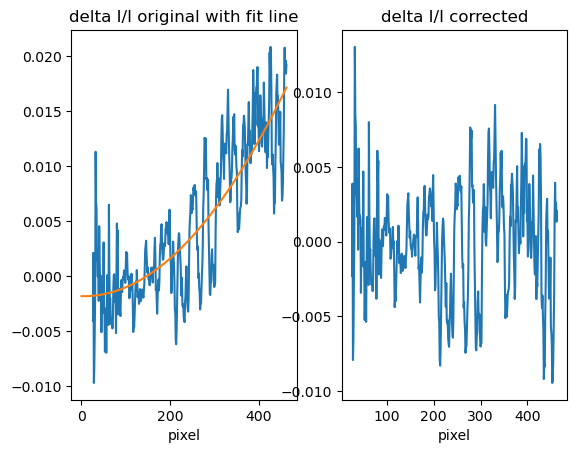

In [ ]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(dI_I_norm[0])
plt.plot(baseline2d[0])
plt.xlabel("pixel")
plt.title("delta I/I original with fit line")

plt.subplot(1,2,2)
plt.plot(corrected_dI[0])
plt.xlabel("pixel")
plt.title("delta I/I corrected")
plt.show()

### Fit only high s

In [ ]:
s_range = np.arange(200, 460, 1)
corrected_dI, baseline2d = fit_high_s(dI_I_norm, s, s_range, return_baseline=True)
dI_I_ave = np.nanmean(dI_I_norm, axis=0)
corrected_ave = np.nanmean(corrected_dI, axis=0)
baseline_ave = np.nanmean(baseline2d, axis=0)

<ipython-input-185-35debd352dab>:3: RuntimeWarning: Mean of empty slice
  dI_I_ave = np.nanmean(dI_I_norm, axis=0)
<ipython-input-185-35debd352dab>:4: RuntimeWarning: Mean of empty slice
  corrected_ave = np.nanmean(corrected_dI, axis=0)


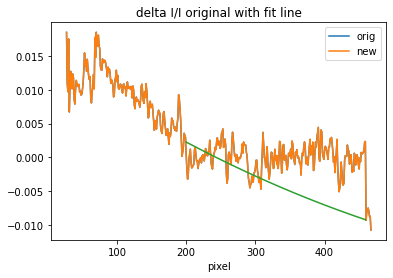

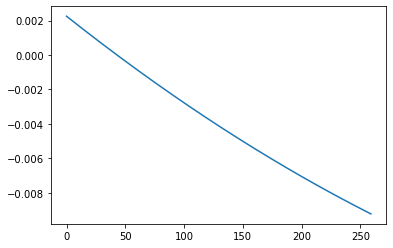

In [ ]:
plt.figure()
plt.plot(dI_I_norm[10], label="orig")
plt.plot(corrected_dI[10], label="new")
plt.plot(s_range, baseline2d[10])
plt.legend()
#plt.plot(baseline2d[20])
plt.xlabel("pixel")
plt.title("delta I/I original with fit line")

plt.show()

plt.figure()
plt.plot(baseline2d[10])
plt.show()

### Plot with Error Bars

In [ ]:
print(corrected_dI.shape)
print(s.shape)
print(uni_stage)

(37, 464)
(464,)
[108.   108.01 108.6  108.61 108.62 108.63 108.64 108.65 108.66 108.67
 108.68 108.69 108.7  108.71 108.72 108.73 108.74 108.75 108.76 108.77
 108.78 108.79 108.8  108.81 108.82 108.85 108.88 108.91 108.94 108.97
 109.05 109.2  109.35 109.5  110.17 111.67 116.17]


26


C:\Users\laure\AppData\Local\Temp\ipykernel_20196\1416765864.py:22: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


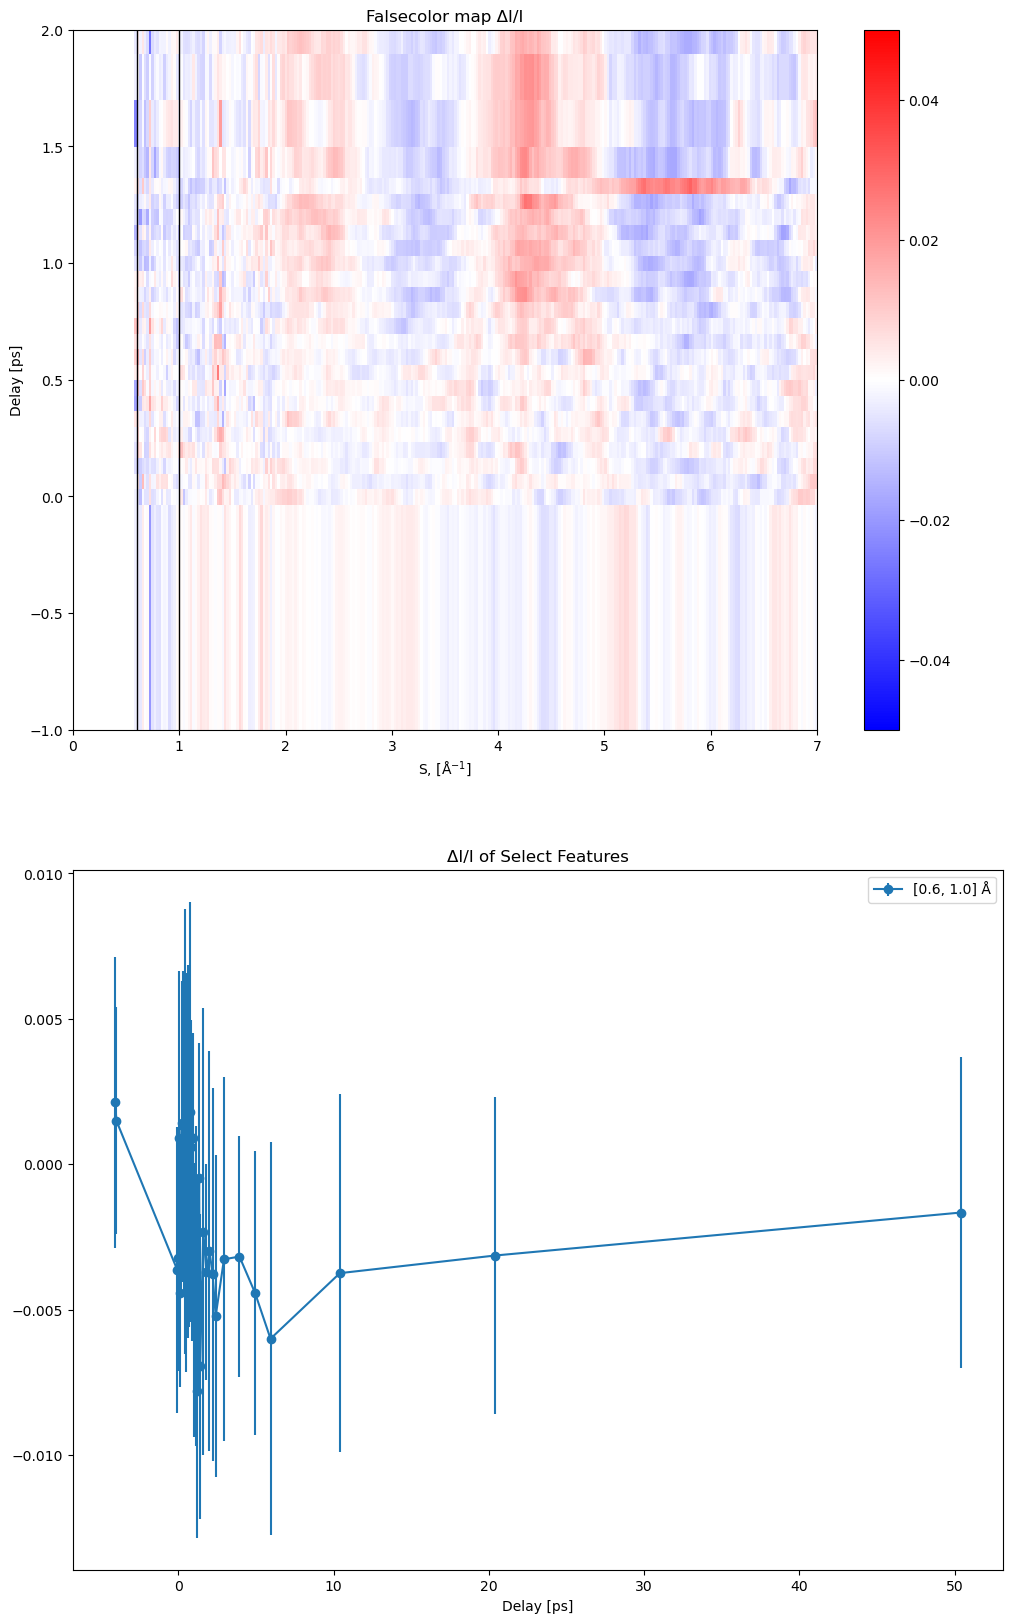

In [ ]:
RoI_1 = [0.6, 1.0];
RoI_2 = [4.0, 4.5];
RoI_3 = [2.0, 2.5];
print(round(RoI_1[0]/s_cali))
Inte_1 = corrected_dI[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
std_1 = corrected_dI[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].std(axis=1)
Inte_2 = corrected_dI[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1);
std_2 = corrected_dI[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].std(axis=1);
Inte_3 = corrected_dI[:,round(RoI_3[0]/s_cali):round(RoI_3[1]/s_cali)].mean(axis=1);
std_3 = corrected_dI[:,round(RoI_3[0]/s_cali):round(RoI_3[1]/s_cali)].std(axis=1);

plt.figure(figsize=(12,20))
plt.subplot(2,1,1)
plt.pcolor(s,realtime,corrected_dI,cmap='bwr');
plt.axvline(x = RoI_1[0], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_1[1], color = 'k', linestyle = '-',linewidth=1);
# plt.axvline(x = RoI_2[0], color = 'k', linestyle = '-',linewidth=1);
# plt.axvline(x = RoI_2[1], color = 'k', linestyle = '-',linewidth=1);
# plt.axvline(x = RoI_3[0], color = 'k', linestyle = '-',linewidth=1);
# plt.axvline(x = RoI_3[1], color = 'k', linestyle = '-',linewidth=1);
plt.clim(vmin=-0.05, vmax=0.05);
plt.colorbar()
plt.ylim(-1, 2)
#plt.ylim(154.35, 154.6)
plt.xlim(0,7)
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Delay [ps]');
plt.title('Falsecolor map ΔI/I')

plt.subplot(2,1,2)
#plt.errorbar(realtime,Inte_1,'-*', yerr=std_1, linewidth=3, label=str(RoI_1)+' '+angs);
#plt.errorbar(realtime,Inte_2,'-*', yerr=std_2, linewidth=3, label=str(RoI_2)+' '+angs);
plt.errorbar(realtime,Inte_1, yerr=std_1,  fmt='-o',  label=str(RoI_1)+' '+angs);
# plt.errorbar(realtime,Inte_2, yerr=std_2,  fmt='-o', label=str(RoI_2)+' '+angs);
# plt.errorbar(realtime,Inte_3, yerr=std_3,  fmt='-o', label=str(RoI_2)+' '+angs);
#plt.xlim(-0.5, 2)
plt.legend()
plt.xlabel('Integrated Yield [arb.]');plt.xlabel('Delay [ps]');plt.title('ΔI/I of Select Features')

plt.show()

In [ ]:
time1 =realtime
t0_1= Inte_2-Inte_1+Inte_3
t0_2 = Inte_2
data1 = corrected_dI
s1 = s
raw_data1 = good_data
time1.shape

(37,)

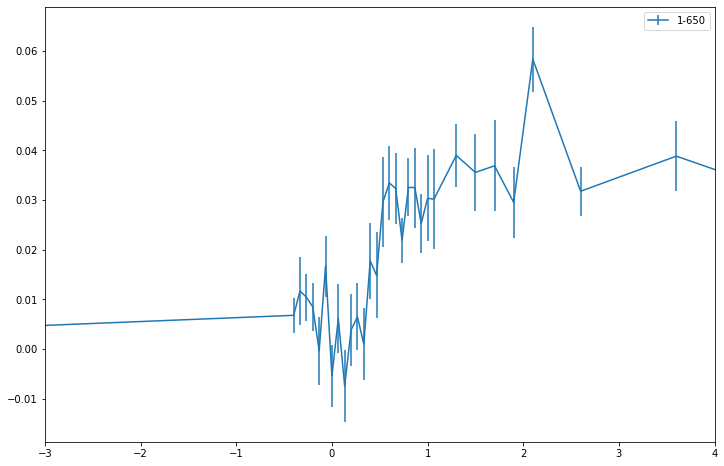

In [ ]:
plt.figure(figsize=(12,8))
plt.errorbar(time1, t0_1, yerr=std_1, label="1-650")
#plt.plot(time2, t0_2, label="651-1300")
#plt.plot(time3, t0_3, label="1301-end")
#plt.plot(time4, t0_4, label="1501-end")
plt.xlim(-3,4)
plt.legend()
plt.show()

## Fitting Rise Time

Uses a selected feature in the data to calculate a rise time based on the `scipy.special.erf()`

Fit parameters: 
t_0 = 0.4496  ps +-  0.0494  ps
FWHM =  0.1738 ps 0.1611 ps




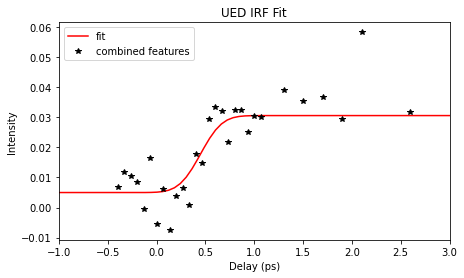

In [ ]:
#Optimise

A = 0.04
t0 = 0.0
sigma = 0.5
offset = -0.1
x0 = [A, t0, sigma,offset]
# ## when fitting with an error function
import scipy
def equations(t, A, t0, sigma, offset): #def equations
    fit = A*(scipy.special.erf((t-t0)/(np.sqrt(2)*sigma)))+offset
    return fit

def erf_fit(t, A, t0, sigma, offset):
    fit = A* scipy.special.erf(((t-t0)/(sigma/(np.sqrt(2*np.log(2)))))*np.sqrt(2))+offset
    return fit 

# yo = equations(t, A, t0, sigma, offset) #equations
popt, pcov, id, _, _ = curve_fit(erf_fit, time1[2:], t0_1[2:], p0 = x0, maxfev = 5000000, method='lm',full_output=True)
t_new = np.linspace(realtime[0],realtime[-1],1000)
## error func fit
A, t0, sigma, offset = popt
print("Fit parameters: ")
print("=====================================================")

print("t_0 =", '%1.4f '%(popt[1]),'ps +- ','%1.4f '%np.sqrt(pcov[1,1]),"ps")
print("FWHM = ", '%1.4f'%(popt[2]), 'ps', '%1.4f' %np.sqrt(pcov[2,2]), "ps")

print("\n")
y_new = equations(t_new, *popt)
plt.figure(figsize=(7,4))
# plt.plot(t,yo,color=‘purple’,ls=‘--’)
plt.plot(t_new,y_new,color='red', label="fit")
plt.plot(time1, t0_1,'*',color='black', label="combined features")
plt.xlim(-1,3)
plt.xlabel("Delay (ps)")
plt.ylabel("Intensity")
plt.title("UED IRF Fit")
plt.legend()
plt.show()

## Save Data 

In [ ]:
exp_label = "s4"
file_range = str(min(good_range)) +"-" + str(max(good_range)+1)
today = date.today()
print(file_range)
print(today)

3000-4000
2024-05-15


In [ ]:
np.savetxt(f"data_files/dI_corrected_{exp_label}_{file_range}_{today}.txt", corrected_dI)
np.savetxt(f"data_files/s_{exp_label}_{file_range}_{today}.txt", s)
np.savetxt(f"data_files/realtime_{exp_label}_{file_range}_{today}.txt", realtime)
np.savetxt(f"data_files/stage_{exp_label}_{file_range}_{today}.txt", uni_stage)
np.savetxt(f"data_files/norm_data_{exp_label}_{file_range}_{today}.txt", norm_data)
np.savetxt(f"data_files/norm_ref_{exp_label}_{file_range}_{today}.txt", norm_ref)

## Gaussian Filtering

In [ ]:
gf_data = gaussian_filter_2d(corrected)

<ipython-input-43-0e6894719926>:11: RuntimeWarning: Mean of empty slice
  azi_data_norm_ref = np.nanmean(norm_data[:N_ref],axis=0);         # Reference signal before T0
<ipython-input-43-0e6894719926>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(s,realtime,gf_data,cmap='bwr');


98


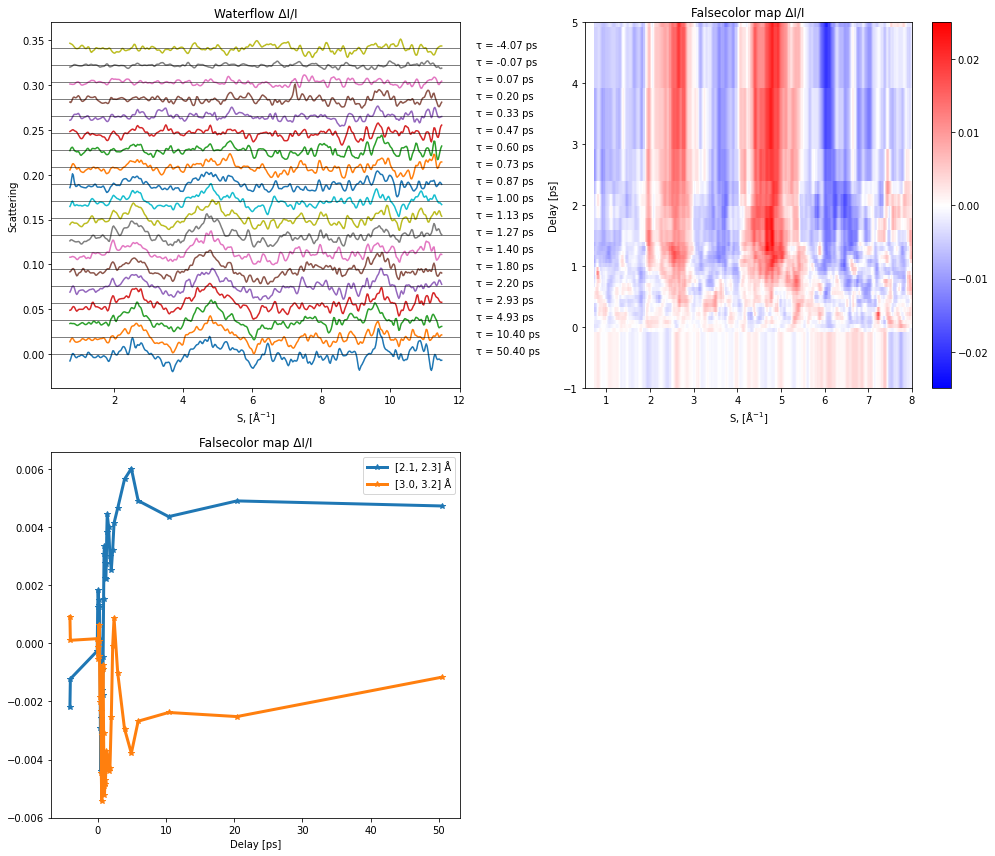

In [ ]:
# (3) Plot the figure: Plot the time-dependent signal
angs = '\u00C5'; # angstrom sign
s_cali = 0.0248 # S calibration in experiment
s = np.arange(0,len(azi_data[0]))*s_cali # The Q axis
realtime = (uni_stage-posi_0)/0.15  # Delay axis in ps

if stage_len<5: # Make up the reference signals
    N_ref = 2
else:
    N_ref = 4
azi_data_norm_ref = np.nanmean(norm_data[:N_ref],axis=0);         # Reference signal before T0
dI_I_norm = (norm_data-azi_data_norm_ref)/azi_data_norm_ref; # Calculate the percentage difference signal

# Plot a figure of the time-depdendent signal of scattering percentage difference.
plt.figure(figsize=(14,12))

plt.subplot(2,2,1)
for i in range(stage_len):
    if i%2 == 0:
        plt.plot(s,gf_data[stage_len-i-1] + np.nanmax(gf_data)*(i)/3);
        plt.text(s[-1]+1,np.nanmax(gf_data)*(i)/3, r'τ = {0:.2f} ps'.format(realtime[stage_len-i-1]))
        plt.axhline(y = np.nanmax(gf_data)*(i)/3, color = 'k', linestyle = '-',linewidth=0.5);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');
plt.ylabel('Scattering');
plt.title('Waterflow ΔI/I');

plt.subplot(2,2,2)
plt.pcolor(s,realtime,gf_data,cmap='bwr');
plt.clim(vmin=-0.025, vmax=0.025);
plt.colorbar()
plt.xlim(0.5, 8)
plt.ylim(-1, 5)
plt.xlabel(r'S, ['+angs+'$^{-1}$]');
plt.ylabel('Delay [ps]');
plt.title('Falsecolor map ΔI/I')

plt.subplot(2,2,3)
RoI_1 = [2.1, 2.3];
RoI_2 = [3.0, 3.2];
print(round(RoI_1[0]/0.0215))
Inte_1 = gf_data[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
Inte_2 = gf_data[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1);
plt.plot(realtime,Inte_1,'-*',linewidth=3,label=str(RoI_1)+' '+angs);
plt.plot(realtime,Inte_2,'-*',linewidth=3,label=str(RoI_2)+' '+angs);
plt.legend()
plt.xlabel('Integrated Yield [arb.]');plt.xlabel('Delay [ps]');plt.title('Falsecolor map ΔI/I')

plt.tight_layout()
plt.show()

# plt.tight_layout()
# plt.show()

## Plotting 4 Point Scan

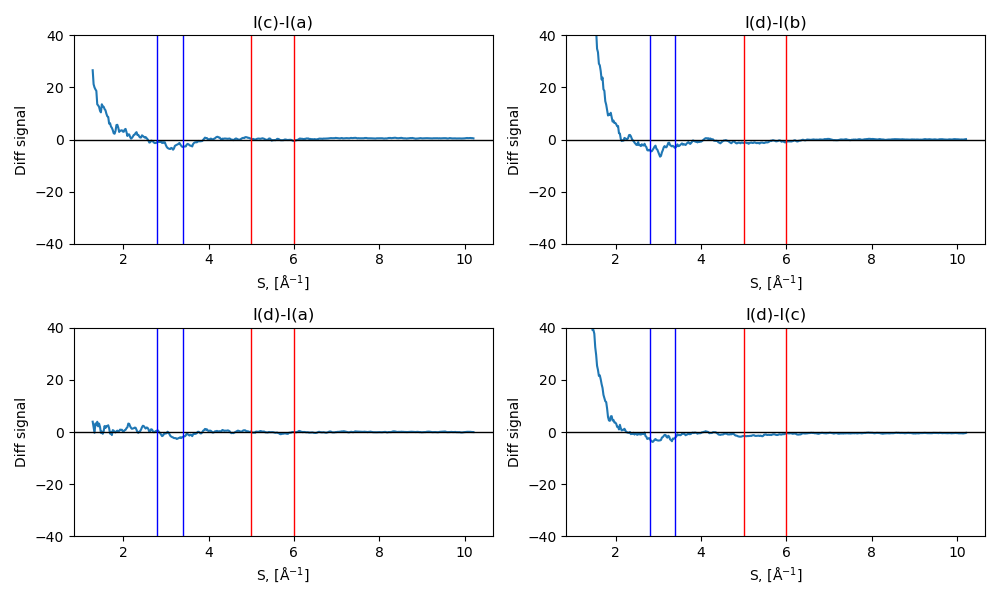

In [ ]:
# (1) A B C D plot
angs = '\u00C5'; # angstrom sign
s_cali = 0.0214 # S calibration in experiment
#posi_0    = 154.405 # The reference T0
posi_0 = 208.955
s = np.arange(0,len(azi_data[0]))*s_cali # The Q axis
realtime = -(uni_stage-posi_0)/0.15  # Delay axis in ps
ROI1 = [5.0,6.0]; # in Angstrom 
ROI2 = [2.8,3.4]; # in Angstrom

plt.figure(figsize=(10,6)) # Fig plot the different analysis

plt.subplot(2,2,1)
diff_1 = (norm_data[1]-norm_data[3])
plt.plot(s[60:], diff_1[60:]);
plt.axhline(y = 0, color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[0], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[1], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[0], color = 'b', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[1], color = 'b', linestyle = '-',linewidth=1);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Diff signal');plt.title('I(c)-I(a)');
plt.ylim([-40, 40]);

plt.subplot(2,2,2)
diff_2 = (norm_data[0]-norm_data[2])
plt.plot(s[60:], diff_2[60:]);
plt.xlabel(r'S, ['+angs+'$^{-1}$]')
plt.ylabel('Diff signal')
plt.title('I(d)-I(b)');
plt.axhline(y = 0, color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[0], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[1], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[0], color = 'b', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[1], color = 'b', linestyle = '-',linewidth=1);
plt.ylim([-40, 40]);

plt.subplot(2,2,3)
diff_3 = (norm_data[2]-norm_data[3])
plt.plot(s[60:], diff_3[60:]);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');
plt.ylabel('Diff signal');
plt.title('I(d)-I(a)');
plt.axhline(y = 0, color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[0], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[1], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[0], color = 'b', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[1], color = 'b', linestyle = '-',linewidth=1);
plt.ylim([-40, 40]);

plt.subplot(2,2,4)
diff_4 = (norm_data[0]-norm_data[1])
plt.plot(s[60:],diff_4[60:]);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');
plt.ylabel('Diff signal');
plt.title('I(d)-I(c)');
plt.axhline(y = 0, color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[0], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[1], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[0], color = 'b', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[1], color = 'b', linestyle = '-',linewidth=1);
plt.ylim([-40, 40]);

plt.tight_layout()
plt.show()

In [ ]:
# (2) Percentage difference signal and scattering ratio plots

if stage_len<=5: # Make up the reference signals
    N_ref = 2
else:
    N_ref = 4
norm_ref = np.nanmean(norm_data[-N_ref:],axis=0);             # Reference signal before T0
dI_I_dlys_Norm  = (norm_data-norm_ref)/norm_ref;    # Calculate the percentage difference signal
DeltaI1 = dI_I_dlys_Norm[:,(s<ROI1[1]) & (s>ROI1[0])].mean(axis=1); #
DeltaI2 = dI_I_dlys_Norm[:,(s<ROI2[1]) & (s>ROI2[0])].mean(axis=1); #
Ratio   = norm_data[:,(s<ROI1[1]) & (s>ROI1[0])].mean(axis=1) / norm_data[:,(s<ROI2[1]) & (s>ROI2[0])].mean(axis=1)

/tmp/ipykernel_641558/105493379.py:7: RuntimeWarning: Mean of empty slice
  norm_ref = np.nanmean(norm_data[-N_ref:],axis=0);             # Reference signal before T0


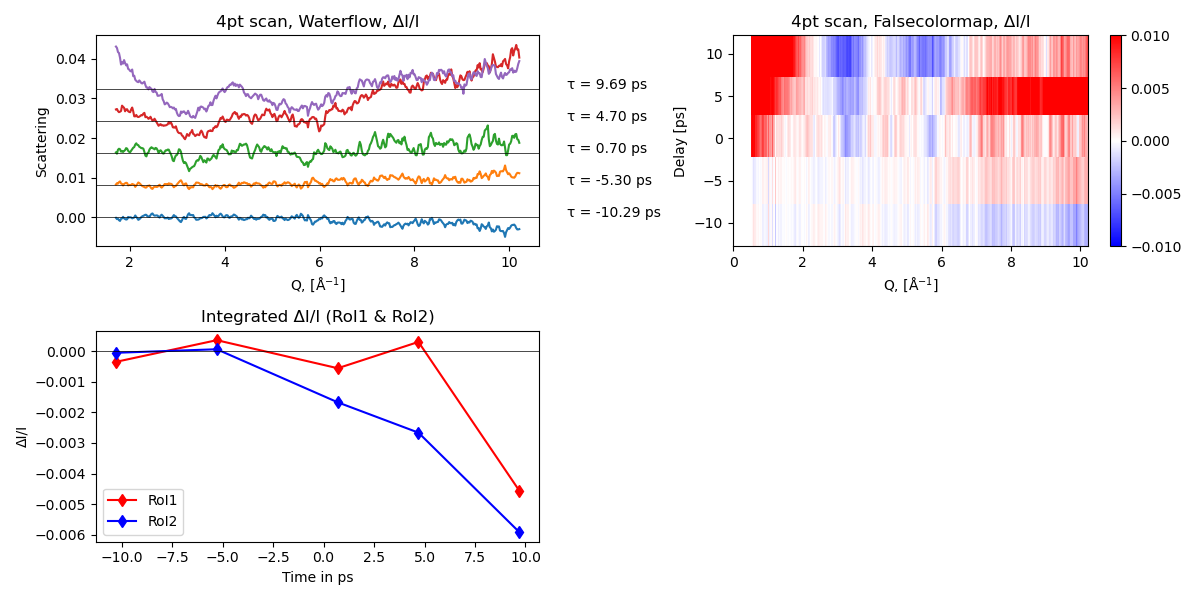

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
for i in range(stage_len):
    plt.plot(s[80:],dI_I_dlys_Norm[stage_len-i-1][80:] + np.nanmax(dI_I_dlys_Norm)*(i)/5);
    plt.text(s[-1]+1,np.nanmax(dI_I_dlys_Norm)*(i)/5, r'τ = {0:.2f} ps'.format(realtime[stage_len-i-1]))
    plt.axhline(y = np.nanmax(dI_I_dlys_Norm)*(i)/5, color = 'k', linestyle = '-',linewidth=0.5);
#plt.axvline(x = ROI1[0], color = 'r', linestyle = '-',linewidth=1);plt.axvline(x = ROI1[1], color = 'r', linestyle = '-',linewidth=1);
#plt.axvline(x = ROI2[0], color = 'b', linestyle = '-',linewidth=1);plt.axvline(x = ROI2[1], color = 'b', linestyle = '-',linewidth=1);
plt.xlabel(r'Q, ['+angs+'$^{-1}$]');plt.ylabel('Scattering');plt.title('4pt scan, Waterflow, ΔI/I');

plt.subplot(2,2,2)
plt.pcolor(s,realtime,dI_I_dlys_Norm,cmap='bwr');plt.clim(vmin=-0.01, vmax=0.01);plt.colorbar()
plt.xlabel(r'Q, ['+angs+'$^{-1}$]');plt.ylabel('Delay [ps]');plt.title('4pt scan, Falsecolormap, ΔI/I')

plt.subplot(2,2,3)
plt.plot(realtime, DeltaI1, '-dr', label='RoI1')
plt.plot(realtime, DeltaI2, '-bd', label='RoI2')
plt.axhline(y=0, color = 'k', linestyle = '-',linewidth=0.5);
plt.xlabel("Time in ps");plt.ylabel('ΔI/I');plt.title('Integrated ΔI/I (RoI1 & RoI2)');
plt.legend()

# plt.subplot(2,2,4)
# plt.plot(realtime,Ratio,'--dg')
# plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Ratio');plt.title('Integrated I (RoI1 vs RoI2)');

plt.tight_layout()
plt.show()

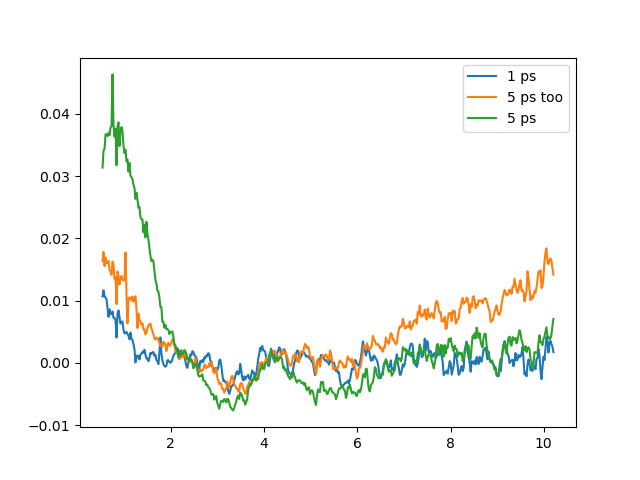

In [ ]:
plt.figure()

plt.plot(s,dI_I_dlys_Norm[2], label="1 ps");
plt.plot(s, dI_I_dlys_Norm[1], label="5 ps too")
plt.plot(s,dI_I_dlys_Norm[0], label="5 ps");
plt.legend()

plt.show()

In [ ]:

corrected_dI, baseline2d = power_fit(dI_I_dlys_Norm , s, return_baseline=True)
dI_I_ave = np.nanmean(dI_I_dlys_Norm , axis=0)
corrected_ave = np.nanmean(corrected_dI, axis=0)
baseline_ave = np.nanmean(baseline2d, axis=0)

/tmp/ipykernel_505790/672403995.py:2: RuntimeWarning: Mean of empty slice
  dI_I_ave = np.nanmean(dI_I_dlys_Norm , axis=0)
/tmp/ipykernel_505790/672403995.py:3: RuntimeWarning: Mean of empty slice
  corrected_ave = np.nanmean(corrected_dI, axis=0)


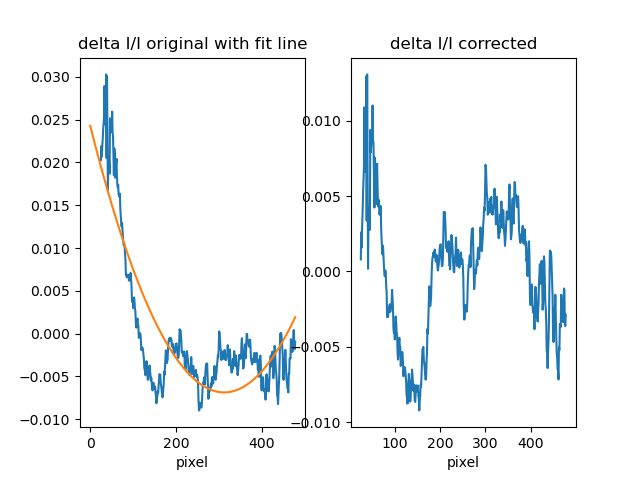

In [ ]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(dI_I_dlys_Norm [0])
plt.plot(baseline2d[0])
plt.xlabel("pixel")
plt.title("delta I/I original with fit line")

plt.subplot(1,2,2)
plt.plot(corrected_dI[0])
plt.xlabel("pixel")
plt.title("delta I/I corrected")
plt.show()

dI_I_dlys_Norm = corrected_dI

## Get PDF

### Calculate PDF

In [ ]:
def get_sM_and_PDF_from_I(dI_I,s,r_max,damp_const):
    """ Calculates and returns the dPDF from the dI_I and s values. s is a 1D array of s values in inverse A. dI_I 1D array of scattering 
    intensities. r_max is the maximum radial value and damp_constant is a damping constant."""
    sM=I_mol/I_at*s #calculate sM from I
    r_max = r_max * 1; # convert to picometer
    r=range(r_max)
    #print(r)
    PDF=[0 for i in range(r_max)]
    for i in range(len(s)-1): 
        PDF+=sM[i]*np.sin(s[i]*1e10*np.array(r)*1e-12)*(s[i+1]-s[i])*np.exp(-s[i]**2/damp_const)
    #for i in range(r_max):
     #   PDF[i]+=sum(sM*np.sin(s*1e10*np.array(r[i])*1e-12)*(s[1]-s[0])*np.exp(-s**2/damp_const))
    return sM,PDF,np.array(r)

def plot_I_sM_PDF(I,sM,PDF,s,r,title_I,title_sM,title_PDF):
    plt.figure()
    plt.subplot(1,3,1)
    plt.plot(s,I/I.max())
    plt.xlabel('s/angs^-1')
    plt.title(title_I)
    plt.grid()
    
    plt.subplot(1,3,2)    
    plt.plot(s,sM)
    plt.xlabel('s/angs^-1')
    plt.title(title_sM)
    plt.grid()
    
    plt.subplot(1,3,3)    
    plt.plot(r,PDF)
    plt.xlabel('r/pm')
    plt.title(title_PDF)
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    return

In [ ]:
def correct_offset(I_ref, I_norm, x=300):
    dI = (I_norm - I_ref)
    corrected = []
    for i in range(len(dI)):
        ends = np.nanmean(dI[i][x:])
        correct = dI[i]- ends
        corrected.append(correct)
        
    corrected = np.array(corrected)
    plt.figure()
    plt.plot(dI[-1][300:], label = "original")
    plt.plot(corrected[-1][300:], label="corrected")
    plt.legend()
    plt.title("Corrected data")
    plt.show()
    return corrected



def s_to_zero(f, s000, s_exp, coor, atom_sum, I_ref, I_norm):
    I_at=np.zeros(len(s_exp)) 
    s000 = s000*1e-10
    for i in range(atom_sum):# the case for single atom scattering, which contributes to I_at
        amps = f[int(coor[i,4])]
        interp_f = interp.interp1d(s000, amps)
        f_new = interp_f(s_exp)
        #print(f_new.shape)
        I_at+=f_new*f_new
    sM_new = []              
    for i in range(len(I_norm)):
        sM_temp = s_exp*(I_norm[i]-I_ref)/I_at
        temp_mean = np.mean(sM_temp[25:30])
        #print(temp_mean)
        slope = temp_mean/25
        sM_temp[0:25] = np.arange(0,25)*slope
        sM_new.append(sM_temp)
    
    sM_new = np.array(sM_new)
    return(sM_new)

# sM_temp = nan(nStage, rMax+1);
    
# for i = 1:nStage
#     sM_temp(i, :) =s.*((I_norm(i, :)-I_ref))./I_atomic;

# end        
# for i = 1:nStage
#     for j = 1:15
#         temp = mean(sM_temp(i, 15:20));
#         slope = temp/15;
#         sM_temp(i, j) = j*slope;
#     end
# end 

In [ ]:
s000

array([0.00000000e+00, 3.69704444e+07, 4.62130555e+07, 5.54556667e+07,
       6.46982778e+07, 7.39408889e+07, 8.31835000e+07, 9.24261111e+07,
       1.01668722e+08, 1.10911333e+08, 1.20153944e+08, 1.29396556e+08,
       1.38639167e+08, 1.47881778e+08, 1.57124389e+08, 1.66367000e+08,
       1.75609611e+08, 1.84852222e+08, 1.94094833e+08, 2.03337444e+08,
       2.12580055e+08, 2.21822667e+08, 2.31065278e+08, 2.40307889e+08,
       2.49550500e+08, 2.58793111e+08, 2.68035722e+08, 2.77278333e+08,
       2.86520944e+08, 2.95763555e+08, 3.05006167e+08, 3.14248778e+08,
       3.23491389e+08, 3.32734000e+08, 3.41976611e+08, 3.51219222e+08,
       3.60461833e+08, 3.69704444e+08, 4.62130555e+08, 5.54556667e+08,
       6.46982778e+08, 7.39408889e+08, 8.31835000e+08, 9.24261111e+08,
       1.01668722e+09, 1.10911333e+09, 1.20153944e+09, 1.29396556e+09,
       1.38639167e+09, 1.47881778e+09, 1.57124389e+09, 1.66367000e+09,
       1.75609611e+09, 1.84852222e+09, 1.94094833e+09, 2.03337444e+09,
      

(37, 464)


<ipython-input-125-056abd999180>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(s, realtime, sM,cmap='bwr')


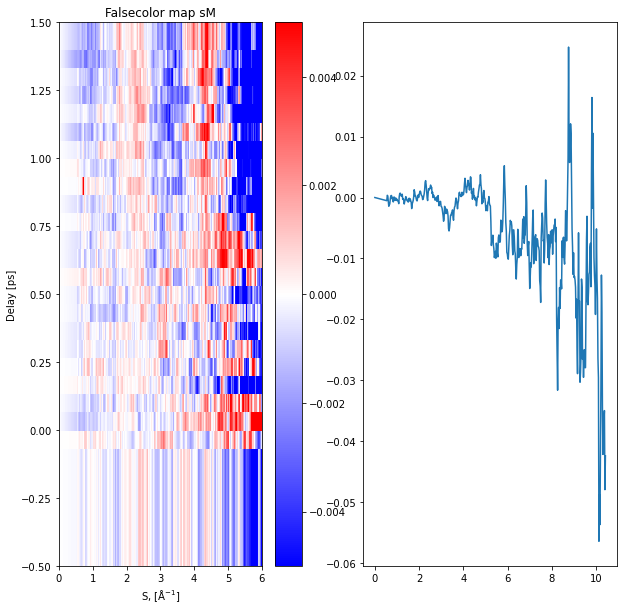

In [ ]:
sM = s_to_zero(f, s000, s, coor, atom_sum, norm_ref, norm_data)
print(sM.shape)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.pcolor(s, realtime, sM,cmap='bwr')
plt.clim(vmin=-0.005, vmax=0.005);
plt.colorbar()
plt.ylim(-0.5, 1.5)
plt.xlim(0, 6)
plt.xlabel(r'S, ['+angs+'$^{-1}$]')
plt.ylabel('Delay [ps]')
plt.title('Falsecolor map sM')

plt.subplot(1,2,2)
plt.plot(s, sM[-1])
plt.show()

(37, 464)


<ipython-input-123-6c9d4cbdcdac>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(s, realtime, sM1,cmap='bwr')


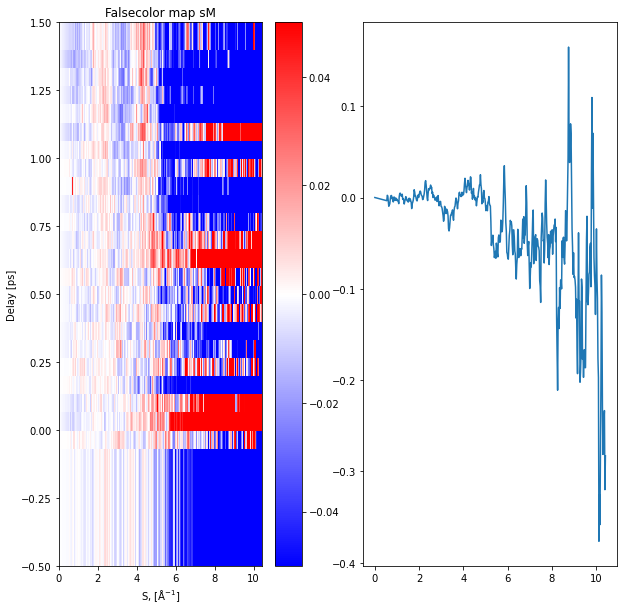

In [ ]:
sM1 = sM/np.max(sM)
print(sM1.shape)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.pcolor(s, realtime, sM1,cmap='bwr')
plt.clim(vmin=-0.05, vmax=0.05);
plt.colorbar()
plt.ylim(-0.5, 1.5)
plt.xlabel(r'S, ['+angs+'$^{-1}$]')
plt.ylabel('Delay [ps]')
plt.title('Falsecolor map sM')

plt.subplot(1,2,2)
plt.plot(s, sM1[-1])
plt.show()

<ipython-input-120-22f992084f3c>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(s, realtime, sM_bkg_rmv,cmap='bwr')


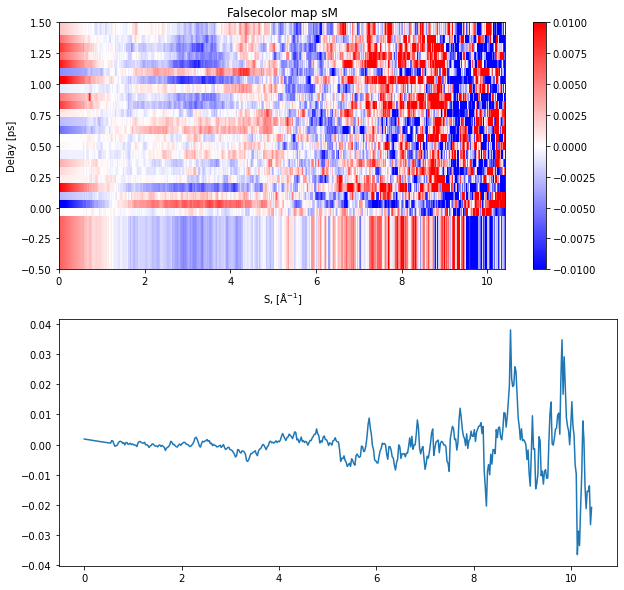

In [ ]:
def poly_remove_bkg(s1,data):
    z=np.polyfit(s1,data,2)
    p=np.poly1d(z)
    Ivals=p(s1)
    bkg_removed=data-Ivals
    return bkg_removed

sM_bkg_rmv = []
for i in range(len(sM)):
    bkg_rmv = poly_remove_bkg(s, sM[i])
    sM_bkg_rmv.append(bkg_rmv)
sM_bkg_rmv = np.array(sM_bkg_rmv)

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.pcolor(s, realtime, sM_bkg_rmv,cmap='bwr')
plt.clim(vmin=-0.01, vmax=0.01);
plt.colorbar()
plt.ylim(-0.5, 1.5)
plt.xlabel(r'S, ['+angs+'$^{-1}$]')
plt.ylabel('Delay [ps]')
plt.title('Falsecolor map sM')

plt.subplot(2,1,2)
plt.plot(s, sM_bkg_rmv[-1])
plt.show()

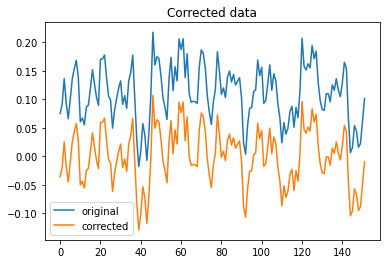

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
       -4.25705345])

In [ ]:
dI_corrected = correct_offset(norm_ref, norm_data)

In [ ]:

plt.figure(figsize=(8,4))
    
plt.subplot(1,2,1)    
plt.plot(s,sM);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('sM(s)');plt.title('Modified Scattering Intensity');plt.grid()
    
plt.subplot(1,2,2)    
plt.plot(r,PDF);
plt.xlabel(r'R, [pm]');
plt.ylabel('PDF');
plt.title('Pair Distribution Function');
plt.grid()
    
plt.tight_layout()
plt.show()

## Plotting Static Signal

/tmp/ipykernel_4068204/2206821370.py:20: RuntimeWarning: Mean of empty slice
  I_ground_state = np.nanmean(norm_data[5:20], axis=0)


zeros:
[1.562837423440269, 4.987067620448715, 6.570421040984097, 8.405056923266985, 10.16498577371641]


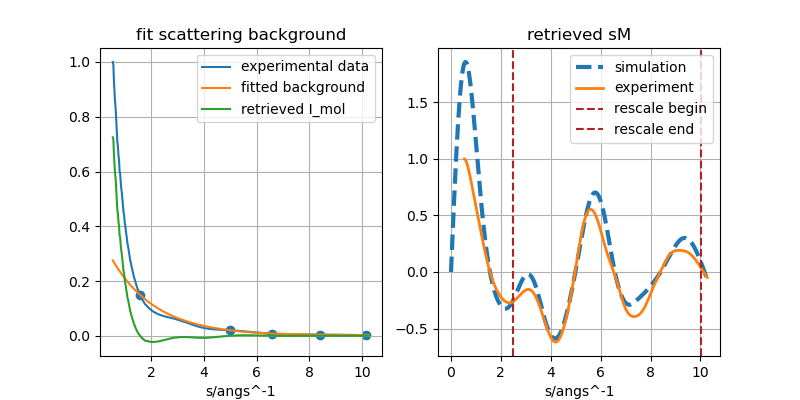

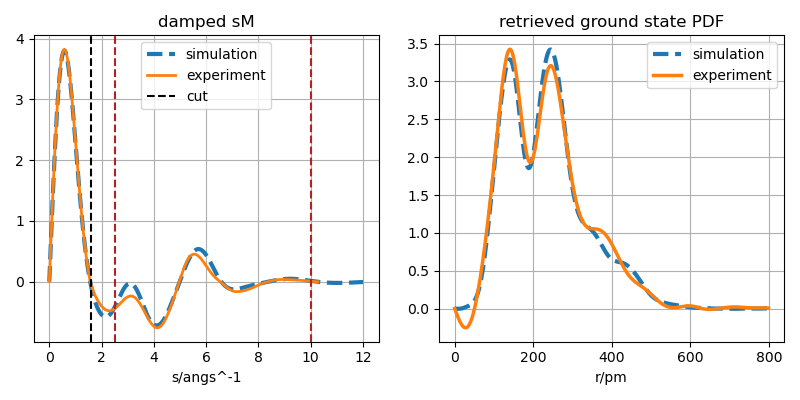

In [ ]:
# (4) Extratin the static scattering signal

path_mol='/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/Molecular_coordinates/';     # The molecular .xyz/.csv pathes
mol_name='NMP';file_type='.csv'; # Molecular geometries, .xyz or .csv file, coordinates saved in 'Molecular_coordinates'

f     = import_DCS(55) # Form factor (partial scattering crosssecton), loadint the IAM form factor with z<55, probably enough for most of orgnic molecules
s000  = import_s()     # Q axis 
s_max = 12             # Max Q range
r_max = 800            # Max R range
damp_const=33          # damping factor
[coor,atom_sum]  = load_static_mol_coor(path_mol,mol_name,file_type);
[I,I_at,I_mol,s] = get_I_from_mol_coor(f,s000,s_max,coor,atom_sum);
# [sM,PDF,r]       = get_sM_and_PDF_from_I(I_at,I_mol,s,r_max,damp_const)

s_cali = 0.0214 # S calibration in experiment
left   = 2.5    # Left side range in S
right  = 10     # Right side range in S

I_ground_state=norm_ref; # experimental static scattering signal
I_ground_state = np.nanmean(norm_data[5:20], axis=0)

retrieve_PDF(left,right,s_cali,f,s000,s_max,coor,atom_sum,damp_const,r_max,I_ground_state);# function to retrive to retrive the static signal